In [1]:
import findspark
findspark.init()
import pandas as pd
from pyspark.sql.functions import col, explode
from pyspark import SparkContext

### Initiate spark session

In [2]:
from pyspark.sql import SparkSession
sc = SparkContext
# sc.setCheckpointDir('checkpoint')
spark = SparkSession.builder.appName('Recommendations').getOrCreate()

# 1. Load data

In [3]:
data = spark.read.csv("/home/ksn38/data/transaction_data.csv", header=True)
data = data.toDF(*[col.lower() for col in data.columns])
data = data.withColumnRenamed('product_id','item_id').withColumnRenamed('household_key','user_id')
data.show(3)

+-------+-----------+---+-------+--------+-----------+--------+-----------+----------+-------+-----------+-----------------+
|user_id|  basket_id|day|item_id|quantity|sales_value|store_id|retail_disc|trans_time|week_no|coupon_disc|coupon_match_disc|
+-------+-----------+---+-------+--------+-----------+--------+-----------+----------+-------+-----------+-----------------+
|   2375|26984851472|  1|1004906|       1|       1.39|     364|       -0.6|      1631|      1|          0|                0|
|   2375|26984851472|  1|1033142|       1|       0.82|     364|          0|      1631|      1|          0|                0|
|   2375|26984851472|  1|1036325|       1|       0.99|     364|       -0.3|      1631|      1|          0|                0|
+-------+-----------+---+-------+--------+-----------+--------+-----------+----------+-------+-----------+-----------------+
only showing top 3 rows



In [4]:
data.printSchema()

root
 |-- user_id: string (nullable = true)
 |-- basket_id: string (nullable = true)
 |-- day: string (nullable = true)
 |-- item_id: string (nullable = true)
 |-- quantity: string (nullable = true)
 |-- sales_value: string (nullable = true)
 |-- store_id: string (nullable = true)
 |-- retail_disc: string (nullable = true)
 |-- trans_time: string (nullable = true)
 |-- week_no: string (nullable = true)
 |-- coupon_disc: string (nullable = true)
 |-- coupon_match_disc: string (nullable = true)



In [5]:
data = data.\
    withColumn('user_id', col('user_id').cast('integer')).\
    withColumn('basket_id', col('basket_id').cast('integer')).\
    withColumn('day', col('day').cast('integer')).\
    withColumn('item_id', col('item_id').cast('integer')).\
    withColumn('quantity', col('quantity').cast('integer')).\
    withColumn('sales_value', col('sales_value').cast('float')).\
    withColumn('store_id', col('store_id').cast('integer')).\
    withColumn('retail_disc', col('retail_disc').cast('float')).\
    withColumn('week_no', col('week_no').cast('integer')).\
    withColumn('coupon_disc', col('coupon_disc').cast('integer')).\
    withColumn('coupon_match_disc', col('coupon_match_disc').cast('float')).\
    drop('trans_time')
data.show(3)

+-------+---------+---+-------+--------+-----------+--------+-----------+-------+-----------+-----------------+
|user_id|basket_id|day|item_id|quantity|sales_value|store_id|retail_disc|week_no|coupon_disc|coupon_match_disc|
+-------+---------+---+-------+--------+-----------+--------+-----------+-------+-----------+-----------------+
|   2375|     null|  1|1004906|       1|       1.39|     364|       -0.6|      1|          0|              0.0|
|   2375|     null|  1|1033142|       1|       0.82|     364|        0.0|      1|          0|              0.0|
|   2375|     null|  1|1036325|       1|       0.99|     364|       -0.3|      1|          0|              0.0|
+-------+---------+---+-------+--------+-----------+--------+-----------+-------+-----------+-----------------+
only showing top 3 rows



In [6]:
data.describe().show()

+-------+------------------+---------+------------------+-----------------+------------------+------------------+-----------------+-------------------+------------------+--------------------+--------------------+
|summary|           user_id|basket_id|               day|          item_id|          quantity|       sales_value|         store_id|        retail_disc|           week_no|         coupon_disc|   coupon_match_disc|
+-------+------------------+---------+------------------+-----------------+------------------+------------------+-----------------+-------------------+------------------+--------------------+--------------------+
|  count|           2595732|        0|           2595732|          2595732|           2595732|           2595732|          2595732|            2595732|           2595732|             2595732|             2595732|
|   mean|1271.9525170549193|     null| 388.7562217517063|2891435.159594673| 100.4285581100052|3.1041197828967073|3142.673210870768|-0.53870539843797

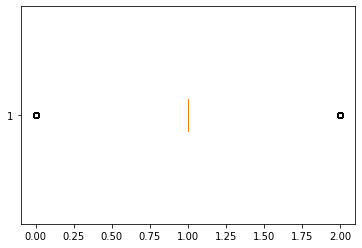

In [35]:
import matplotlib.pyplot as plt

quantity_arr = [int(x.quantity) for x in data.select('quantity').where(col('quantity') < 3).collect()]
plt.boxplot(quantity_arr, vert=False)
plt.show()

In [40]:
data.select('quantity').where(col('quantity') > 3).count()/data.select('quantity').count()

0.035043679393712446

In [48]:
data2 = data.select('*').where(col('quantity') < 3)
data2.show()

+-------+---------+---+-------+--------+-----------+--------+-----------+-------+-----------+-----------------+
|user_id|basket_id|day|item_id|quantity|sales_value|store_id|retail_disc|week_no|coupon_disc|coupon_match_disc|
+-------+---------+---+-------+--------+-----------+--------+-----------+-------+-----------+-----------------+
|   2375|     null|  1|1004906|       1|       1.39|     364|       -0.6|      1|          0|              0.0|
|   2375|     null|  1|1033142|       1|       0.82|     364|        0.0|      1|          0|              0.0|
|   2375|     null|  1|1036325|       1|       0.99|     364|       -0.3|      1|          0|              0.0|
|   2375|     null|  1|1082185|       1|       1.21|     364|        0.0|      1|          0|              0.0|
|   2375|     null|  1|8160430|       1|        1.5|     364|      -0.39|      1|          0|              0.0|
|   2375|     null|  1| 826249|       2|       1.98|     364|       -0.6|      1|          0|           

In [7]:
test_size_weeks = 7

data_train = data[data['week_no'] < data['week_no'].max() - val_lvl_1_size_weeks]
data_test = data[(data['week_no'] >= data['week_no'].max() - val_lvl_1_size_weeks)]

TypeError: 'Column' object is not callable

## Calculate sparsity

In [7]:
# Count the total number of data in the dataset
numerator = data.select("rating").count()
print('numerator', numerator)

# Count the number of distinct userIds and distinct movieIds
num_users = data.select("userId").distinct().count()
num_movies = data.select("movieId").distinct().count()
print('num_users', num_users)
print('num_movies', num_movies)

# Set the denominator equal to the number of users multiplied by the number of movies
denominator = num_users * num_movies
print('denominator', denominator)

# Divide the numerator by the denominator
sparsity = (1.0 - (numerator *1.0)/denominator)*100
print("The data dataframe is ", "%.2f" % sparsity + "% empty.")

The ratings dataframe is  98.30% empty.


## Interpret ratings

## Build Out An ALS Model

In [9]:
# Import the required functions
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

In [11]:
# Create test and train set
(train, test) = ratings.randomSplit([0.8, 0.2], seed = 1234)

# Create ALS model
als = ALS(userCol="userId", itemCol="movieId", ratingCol="rating", nonnegative = True, implicitPrefs = False, coldStartStrategy="drop")

# Confirm that a model called "als" was created
type(als)

pyspark.ml.recommendation.ALS

## Tell Spark how to tune your ALS model

In [12]:
# Import the requisite items
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Add hyperparameters and their respective values to param_grid
param_grid = ParamGridBuilder() \
            .addGrid(als.rank, [10, 50, 100, 150]) \
            .addGrid(als.regParam, [.01, .05, .1, .15]) \
            .build()
            #             .addGrid(als.maxIter, [5, 50, 100, 200]) \

           
# Define evaluator as RMSE and print length of evaluator
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction") 
print ("Num models to be tested: ", len(param_grid))

Num models to be tested:  16


## Build your cross validation pipeline

In [13]:
# Build cross validation using CrossValidator
cv = CrossValidator(estimator=als, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=5)

# Confirm cv was built
print(cv)

CrossValidator_54c5bf88093f


## Best Model and Best Model Parameters

In [14]:
#Fit cross validator to the 'train' dataset
model = cv.fit(train)

#Extract best model from the cv model above
best_model = model.bestModel

In [15]:

# Print best_model
print(type(best_model))

# Complete the code below to extract the ALS model parameters
print("**Best Model**")

# # Print "Rank"
print("  Rank:", best_model._java_obj.parent().getRank())

# Print "MaxIter"
print("  MaxIter:", best_model._java_obj.parent().getMaxIter())

# Print "RegParam"
print("  RegParam:", best_model._java_obj.parent().getRegParam())

<class 'pyspark.ml.recommendation.ALSModel'>
**Best Model**
  Rank: 50
  MaxIter: 10
  RegParam: 0.15


In [16]:
# View the predictions
test_predictions = best_model.transform(test)
RMSE = evaluator.evaluate(test_predictions)
print(RMSE)

0.8656510561406606


In [17]:
test_predictions.show()

+------+-------+------+----------+
|userId|movieId|rating|prediction|
+------+-------+------+----------+
|   385|    471|   4.0| 3.2817402|
|   462|    471|   2.5| 2.3096857|
|   387|    471|   3.0| 3.0138159|
|   171|    471|   3.0| 4.4921217|
|    32|    471|   3.0| 3.7683742|
|   469|    471|   5.0| 3.4463875|
|   357|    471|   3.5| 3.9890354|
|   132|   1088|   4.0|  2.749427|
|   563|   1088|   4.0| 3.3631582|
|   594|   1088|   4.5| 4.3264866|
|   307|   1088|   3.0| 2.4013104|
|    51|   1088|   4.0| 3.8586433|
|   221|   1088|   3.0|  3.030849|
|   414|   1088|   3.0| 3.0015788|
|   200|   1088|   4.0|  3.657487|
|   104|   1088|   3.0| 3.6541252|
|    19|   1238|   3.0|   3.22746|
|   156|   1238|   4.0| 3.9635246|
|   425|   1342|   3.5| 2.1818767|
|   600|   1342|   2.5| 2.2087283|
+------+-------+------+----------+
only showing top 20 rows



## Make Recommendations

In [18]:
# Generate n Recommendations for all users
nrecommendations = best_model.recommendForAllUsers(10)
nrecommendations.limit(10).show()

+------+--------------------+
|userId|     recommendations|
+------+--------------------+
|   471|[[3379, 4.6728826...|
|   463|[[3379, 4.8718524...|
|   496|[[3379, 4.521693]...|
|   148|[[93008, 4.373521...|
|   540|[[3379, 5.3770757...|
|   392|[[8477, 4.665325]...|
|   243|[[86237, 5.364011...|
|    31|[[93988, 4.960051...|
|   516|[[3379, 4.789225]...|
|   580|[[3379, 4.6298943...|
+------+--------------------+



In [19]:
nrecommendations = nrecommendations\
    .withColumn("rec_exp", explode("recommendations"))\
    .select('userId', col("rec_exp.movieId"), col("rec_exp.rating"))

nrecommendations.limit(10).show()

+------+-------+---------+
|userId|movieId|   rating|
+------+-------+---------+
|   471|   3379|4.6728826|
|   471| 102217| 4.586662|
|   471|  92494| 4.586662|
|   471|  89904|4.4644165|
|   471| 171495| 4.357144|
|   471|   8477|4.3503823|
|   471|   6442| 4.349947|
|   471|   7767|4.3328934|
|   471|   7748|  4.32773|
|   471|  26326| 4.322282|
+------+-------+---------+



## Do the recommendations make sense?
Lets merge movie name and genres to teh recommendation matrix for interpretability.

In [20]:
nrecommendations.join(movies, on='movieId').filter('userId = 100').show()

+-------+------+---------+--------------------+--------------------+
|movieId|userId|   rating|               title|              genres|
+-------+------+---------+--------------------+--------------------+
|  93008|   100|4.9257135|Very Potter Seque...|      Comedy|Musical|
|  77846|   100|4.9257135| 12 Angry Men (1997)|         Crime|Drama|
|  25906|   100|4.9257135|Mr. Skeffington (...|       Drama|Romance|
|   3379|   100| 4.891129| On the Beach (1959)|               Drama|
|  69069|   100| 4.886154|     Fired Up (2009)|              Comedy|
|  74282|   100| 4.857362|Anne of Green Gab...|Children|Drama|Ro...|
|  93988|   100|4.8486333|North & South (2004)|       Drama|Romance|
|   3086|   100| 4.841063|Babes in Toyland ...|Children|Comedy|F...|
|  74226|   100|4.8314667|Dream of Light (a...|   Documentary|Drama|
|  84273|   100|4.8314667|Zeitgeist: Moving...|         Documentary|
+-------+------+---------+--------------------+--------------------+



In [21]:
ratings.join(movies, on='movieId').filter('userId = 100').sort('rating', ascending=False).limit(10).show()

+-------+------+------+--------------------+--------------------+
|movieId|userId|rating|               title|              genres|
+-------+------+------+--------------------+--------------------+
|   1101|   100|   5.0|      Top Gun (1986)|      Action|Romance|
|   1958|   100|   5.0|Terms of Endearme...|        Comedy|Drama|
|   2423|   100|   5.0|Christmas Vacatio...|              Comedy|
|   4041|   100|   5.0|Officer and a Gen...|       Drama|Romance|
|   5620|   100|   5.0|Sweet Home Alabam...|      Comedy|Romance|
|    368|   100|   4.5|     Maverick (1994)|Adventure|Comedy|...|
|    934|   100|   4.5|Father of the Bri...|              Comedy|
|    539|   100|   4.5|Sleepless in Seat...|Comedy|Drama|Romance|
|     16|   100|   4.5|       Casino (1995)|         Crime|Drama|
|    553|   100|   4.5|    Tombstone (1993)|Action|Drama|Western|
+-------+------+------+--------------------+--------------------+

